<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列データの分析を行う
### 使用するデータセットの参考文献
 - https://www.kaggle.com/datasets/javi2270784/gas-sensor-array-temperature-modulation/data
 - Burgués, Javier, Juan Manuel Jiménez-Soto, and Santiago Marco. "Estimation of the limit of detection in semiconductor gas sensors through linearized calibration models." Analytica chimica acta 1013 (2018): 13-25.
 -  Burgués, Javier, and Santiago Marco. "Multivariate estimation of the limit of detection by orthogonal partial least squares in temperature-modulated MOX sensors." Analytica chimica acta 1019 (2018): 49-64.

## データセットのダウンロード
 - https://www.kaggle.com/datasets/javi2270784/gas-sensor-array-temperature-modulation/data からDownload→Download dataset as zipと選択してarchive.zipをダウンロード

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、archive.zipをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

In [3]:
# archive.zipを以下のコマンドで解凍する
! unzip archive.zip -d gas-sensor-array-temperature-modulation

Archive:  archive.zip
  inflating: gas-sensor-array-temperature-modulation/20160930_203718.csv  
  inflating: gas-sensor-array-temperature-modulation/20161001_231809.csv  
  inflating: gas-sensor-array-temperature-modulation/20161003_085624.csv  
  inflating: gas-sensor-array-temperature-modulation/20161004_104124.csv  
  inflating: gas-sensor-array-temperature-modulation/20161005_140846.csv  
  inflating: gas-sensor-array-temperature-modulation/20161006_182224.csv  
  inflating: gas-sensor-array-temperature-modulation/20161007_210049.csv  
  inflating: gas-sensor-array-temperature-modulation/20161008_234508.csv  
  inflating: gas-sensor-array-temperature-modulation/20161010_095046.csv  
  inflating: gas-sensor-array-temperature-modulation/20161011_113032.csv  
  inflating: gas-sensor-array-temperature-modulation/20161013_143355.csv  
  inflating: gas-sensor-array-temperature-modulation/20161014_184659.csv  
  inflating: gas-sensor-array-temperature-modulation/20161016_053656.csv  
  i

## ライブラリをインポート

In [4]:
! pip install lightgbm==4.2.0
! pip install scikit-learn==1.3.2 #ライブラリのverによっては次元圧縮の挙動が異なることがあるため注意
! pip install numpy==1.26.4
! pip install pandas==2.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [5]:
import glob
import os
import warnings

warnings.filterwarnings("ignore")

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import json_normalize
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm

## gas-sensor-array-temperature-modulationに格納されているデータを読み込み、それぞれデータフレームに格納

In [6]:
path = INPUT_FILE_PATH + "gas-sensor-array-temperature-modulation/"

csv_files = glob.glob(os.path.join(path, "*.csv"))

for file_path in csv_files:
    file_name = os.path.basename(file_path).replace(".csv", "")
    globals()[f"df_{file_name}"] = pd.read_csv(file_path)
    print(f"df_{file_name}: {globals()[f'df_{file_name}'].shape}")

df_20161005_140846: (295534, 20)
df_20161010_095046: (295747, 20)
df_20161006_182224: (295499, 20)
df_20161007_210049: (295700, 20)
df_20161003_085624: (295700, 20)
df_20160930_203718: (295719, 20)
df_20161008_234508: (295524, 20)
df_20161014_184659: (295881, 20)
df_20161004_104124: (295653, 20)
df_20161013_143355: (295679, 20)
df_20161011_113032: (295391, 20)
df_20161001_231809: (295516, 20)
df_20161016_053656: (295617, 20)


## 学習データ、検証データを定義

In [7]:
# trainデータとして、df_20160930_203718～df_df_20161014_184659を結合
train = pd.concat(
    [
        df_20160930_203718,
        df_20161001_231809,
        df_20161003_085624,
        df_20161004_104124,
        df_20161005_140846,
        df_20161006_182224,
        df_20161007_210049,
        df_20161008_234508,
        df_20161010_095046,
        df_20161011_113032,
        df_20161013_143355,
        df_20161014_184659,
    ]
)
train

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
0,0.000,0.0,49.7534,23.7184,233.2737,0.8993,0.2231,0.6365,1.1493,0.8483,1.2534,1.4449,1.9906,1.3303,1.4480,1.9148,3.4651,5.2144,6.5806,8.6385
1,0.309,0.0,55.8400,26.6200,241.6323,0.2112,2.1314,5.3552,9.7569,6.3188,9.4472,10.5769,13.6317,21.9829,16.1902,24.2780,31.1014,34.7193,31.7505,41.9167
2,0.618,0.0,55.8400,26.6200,241.3888,0.2070,10.5318,22.5612,37.2635,17.7848,33.0704,36.3160,42.5746,49.7495,31.7533,57.7289,53.6275,56.9212,47.8255,62.9436
3,0.926,0.0,55.8400,26.6200,241.1461,0.2042,29.5749,49.5111,65.6318,26.1447,58.3847,67.5130,68.0064,59.2824,36.7821,66.0832,66.8349,66.9695,50.3730,64.8363
4,1.234,0.0,55.8400,26.6200,240.9121,0.2030,49.5111,67.0368,77.8317,27.9625,71.7732,79.9474,79.8631,62.5385,39.6271,68.1441,62.0947,49.4614,52.8453,66.8445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295876,90908.896,0.0,62.0600,25.1000,0.0000,0.8981,0.2018,0.5607,0.8668,0.6331,0.9859,1.1367,1.6256,1.0065,1.0946,1.4849,2.6780,4.4780,6.0728,7.6403
295877,90909.204,0.0,62.0600,25.1000,0.0000,0.2119,2.1497,5.1727,7.9969,5.4928,7.9933,8.9320,11.9270,23.7481,21.1688,23.8594,33.2957,38.4578,37.0376,45.7715
295878,90909.514,0.0,62.0600,25.1000,0.0000,0.2077,11.7504,23.8667,33.7225,19.7813,31.1327,33.3141,41.1262,66.6625,55.6241,60.1967,60.7607,64.0377,58.9429,71.7899
295879,90909.822,0.0,62.0600,25.1000,0.0000,0.2040,34.9088,52.4949,64.1416,33.6400,59.1755,62.4119,69.6844,73.9623,65.1843,70.3356,77.4430,73.7047,61.9316,74.9537


In [8]:
# validationデータとして20161016_053656を使用
valid = df_20161016_053656
valid

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
0,0.000,0.0,48.4700,24.6200,247.4926,0.2000,0.6831,0.6992,1.1940,16.0255,23.0855,11.2872,19.5953,53.0355,47.0753,55.1962,63.9090,51.8182,49.4775,63.3641
1,0.309,0.0,48.4700,24.6200,243.8282,0.1998,0.6649,0.6976,1.1514,15.2863,22.4605,10.3764,18.5686,53.0355,48.4789,52.8143,62.4980,50.3466,49.7900,63.3641
2,0.618,0.0,48.4700,24.6200,243.0668,0.2000,0.6481,0.6863,1.1133,14.3923,20.8138,9.8742,17.7525,43.7627,47.3693,55.5168,57.9038,51.5393,50.0533,65.8253
3,0.928,0.0,48.4700,24.6200,242.3030,0.2000,0.6318,0.6757,1.0795,14.0074,19.5772,9.3127,16.6801,53.0355,46.8330,51.5578,63.9090,52.4422,49.2201,62.4461
4,1.237,0.0,48.4702,24.6206,241.5632,0.2000,0.6178,0.6659,1.0480,13.1437,18.6348,8.7301,15.6956,59.7614,46.3085,54.5033,57.5565,51.5393,49.4775,64.8363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295612,90908.534,0.0,63.9400,24.6200,0.0000,0.2080,9.9322,19.1578,30.1225,17.4705,28.2241,29.2848,35.2025,54.4724,51.7813,59.3023,63.4039,61.3484,53.8044,65.2822
295613,90908.843,0.0,63.9400,24.6200,0.0000,0.2050,31.7887,50.6638,62.3092,32.0334,54.3512,57.2118,64.5292,78.2372,63.7388,69.2228,68.3506,70.6909,62.4181,74.9537
295614,90909.151,0.0,63.9400,24.6200,0.0000,0.2040,57.7304,76.9383,80.6932,38.9931,82.5354,74.2258,77.0531,53.0355,70.6869,75.8734,76.1033,71.3160,61.0589,73.6785
295615,90909.461,0.0,63.9400,24.6200,0.0000,0.2020,71.9176,82.0040,86.3116,40.7134,79.5571,83.9107,86.1372,82.1159,67.2807,71.4844,68.3506,74.2698,62.4181,74.9537


## データを可視化

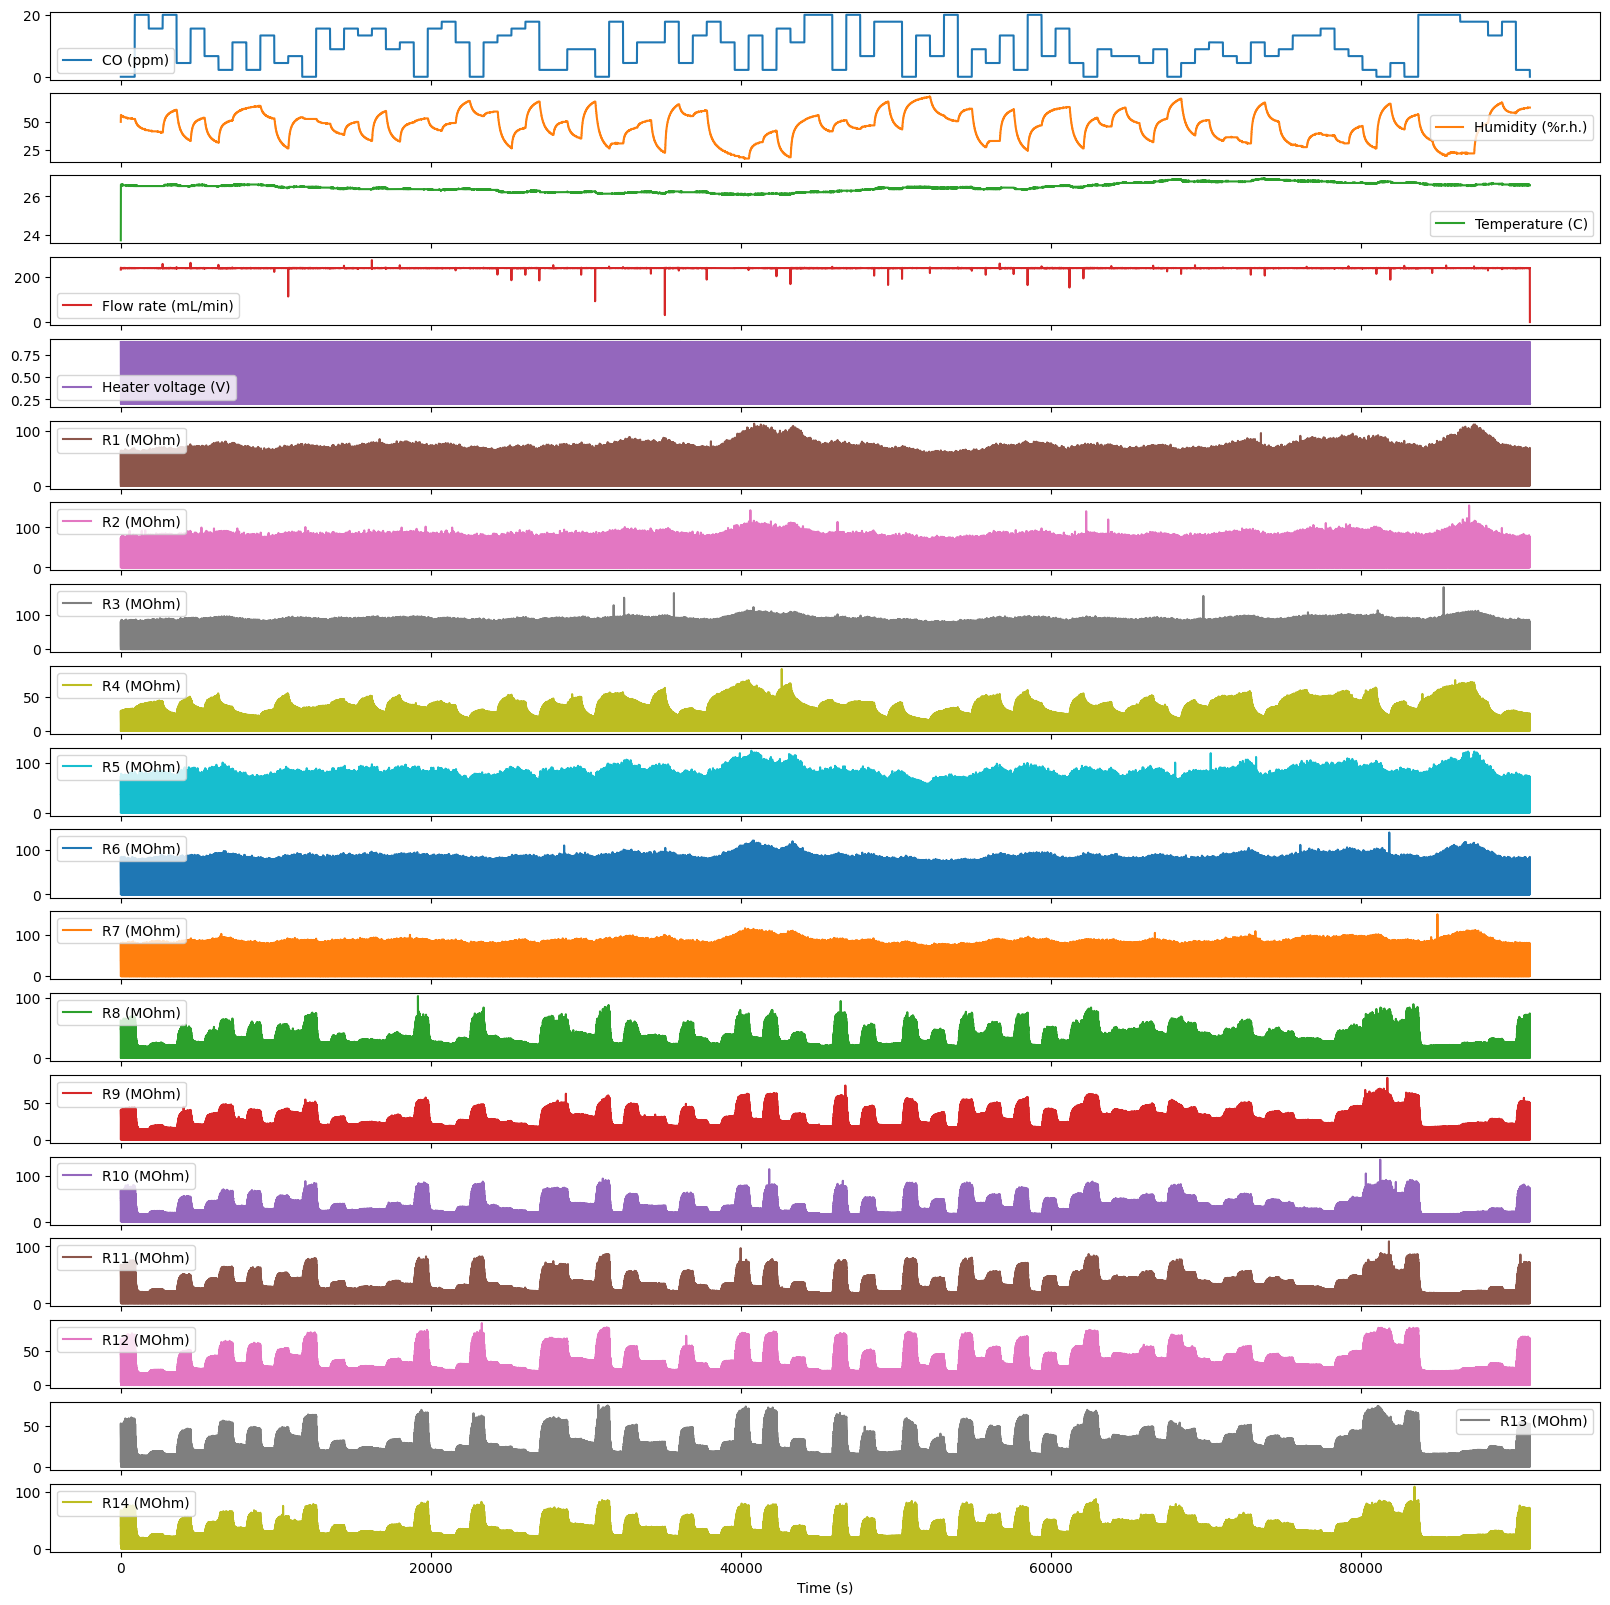

In [9]:
# df_20160930_203718を代表例として、Time (s)を横軸に、縦軸にそれ以外の列を取り、データを可視化
df_20160930_203718.plot(x="Time (s)", subplots=True, figsize=(20, 20))
plt.show()

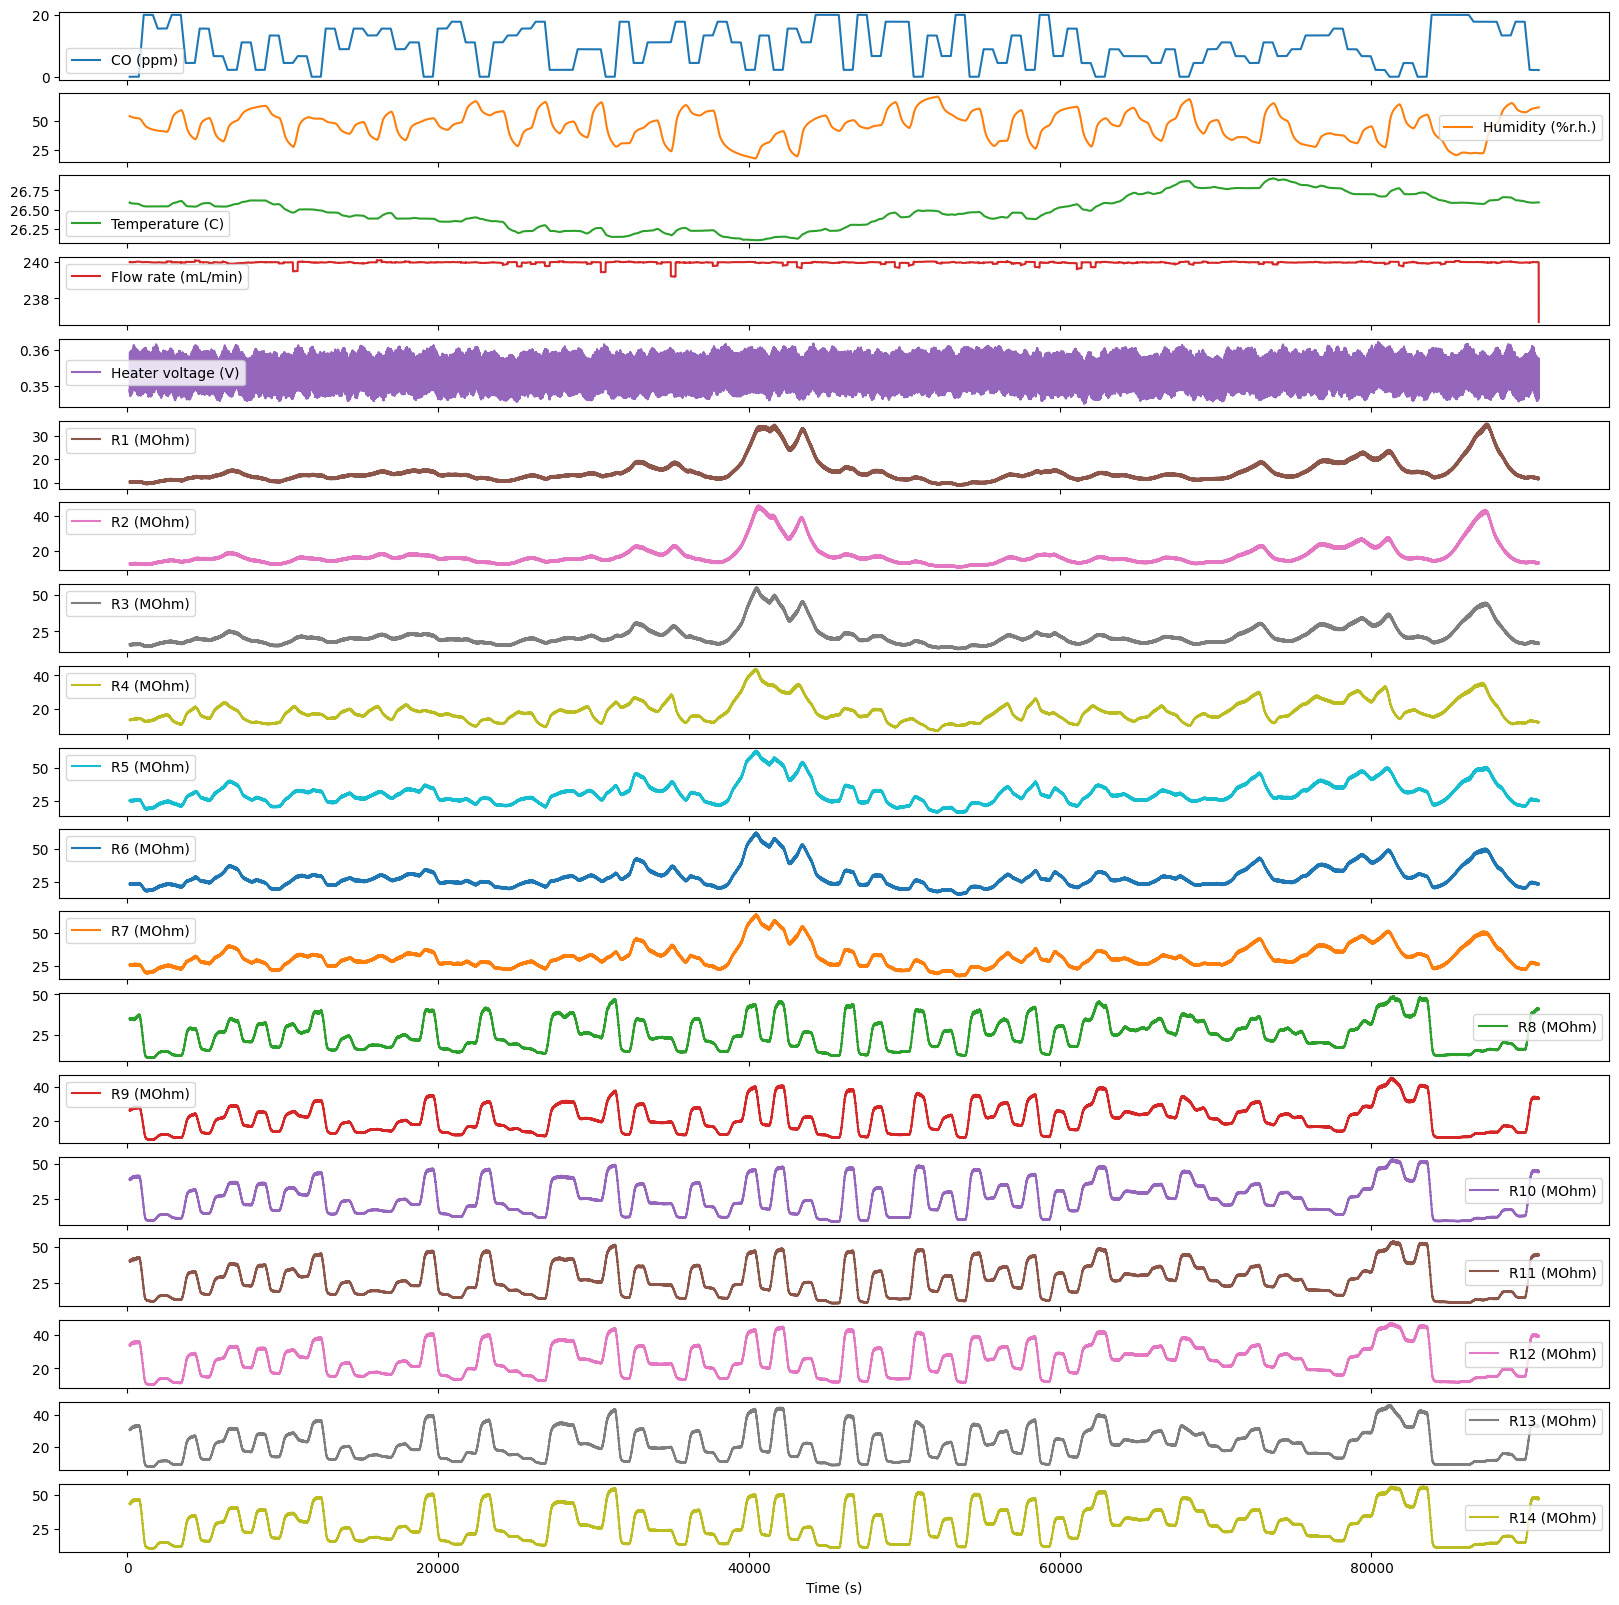

In [10]:
# df_20160930_203718を代表例として、Time (s)を横軸に、縦軸にそれ以外の列を取り、移動平均を適用してデータを可視化
df_20160930_203718_smoothed = df_20160930_203718.rolling(window=1000).mean()
df_20160930_203718_smoothed.plot(x="Time (s)", subplots=True, figsize=(20, 20))
plt.show()

## 回帰モデルを構築する

In [11]:
# X_train, y_train, X_valid, y_validを作成
X_train = train.drop(columns=["Time (s)", "CO (ppm)"])
y_train = train["CO (ppm)"]
X_valid = valid.drop(columns=["Time (s)", "CO (ppm)"])
y_valid = valid["CO (ppm)"]

In [12]:
params = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42,
    "max_depth": 5,
    "n_estimators": 10000,  # "n_estimators": 1000ではearly_stopping(stopping_rounds=10)で収束しない
    "colsample_bytree": 0.7,
}
model = lgbm.LGBMRegressor(**params, verbose=-1)  # ログ出力を抑制
model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    callbacks=[lgbm.early_stopping(stopping_rounds=10)],
)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3261]	valid_0's rmse: 2.14159	valid_0's l2: 4.5864


LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=5,
              n_estimators=10000, objective='regression', random_state=42,
              reg_alpha=0.1, reg_lambda=0.1, verbose=-1)

## 特徴量重要度を算出

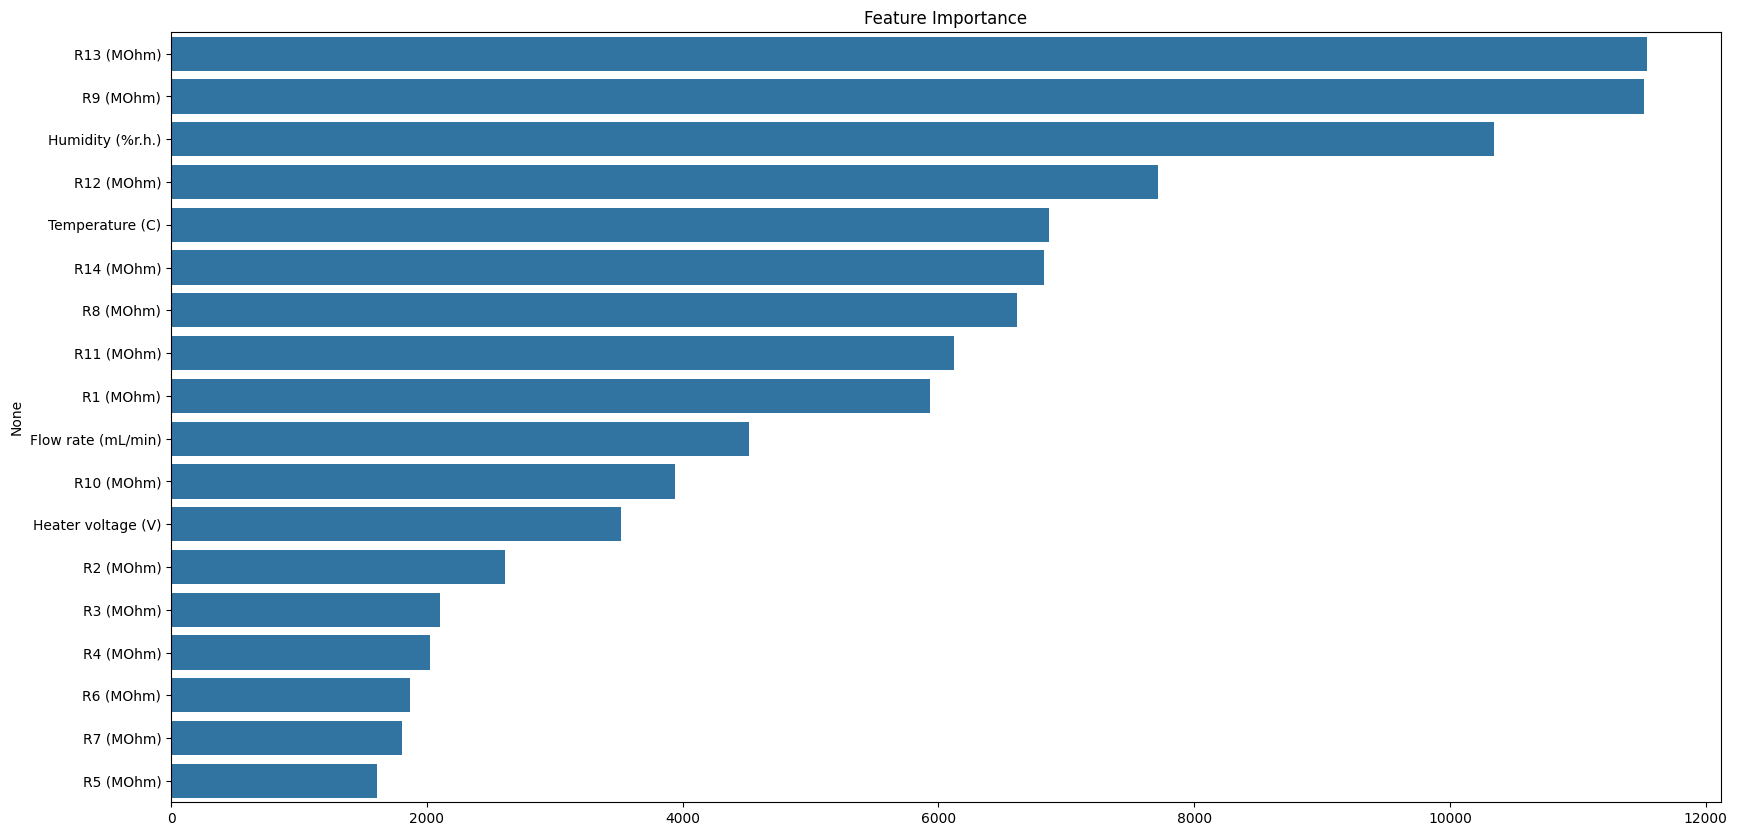

In [13]:
# modelのfeature_importances_を取得
feature_importance = model.feature_importances_
# feature_importanceを大きい順に並び替え
indices = np.argsort(feature_importance)[::-1]
# feature_importanceを可視化
plt.figure(figsize=(20, 10))
plt.title("Feature Importance")
sns.barplot(x=feature_importance[indices], y=X_train.columns[indices])
plt.show()

## 検証データにおける予測を行い、予測結果を可視化する

In [14]:
# vallidの予測値を求める
valid_preds = model.predict(X_valid, num_iteration=model.best_iteration_)
# validの予測値と正解値でRMSEとMAEを求める
rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
mae = mean_absolute_error(y_valid, valid_preds)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 2.141587450051015
MAE: 1.2257499607309428


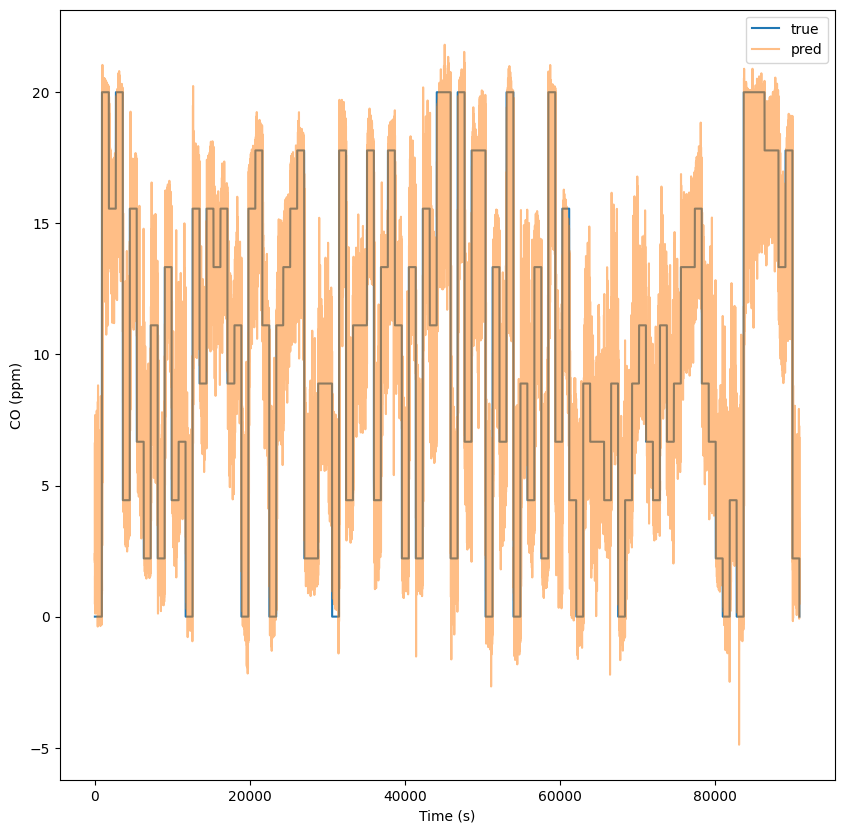

In [15]:
# y_valid, valid_predsを縦軸、横軸にTime (s)を取り、グラフを描画
plt.figure(figsize=(10, 10))
plt.plot(valid["Time (s)"], y_valid, label="true")
plt.plot(valid["Time (s)"], valid_preds, label="pred", alpha=0.5)
# 縦軸、横軸にラベルを付ける
plt.xlabel("Time (s)")
plt.ylabel("CO (ppm)")
plt.legend()

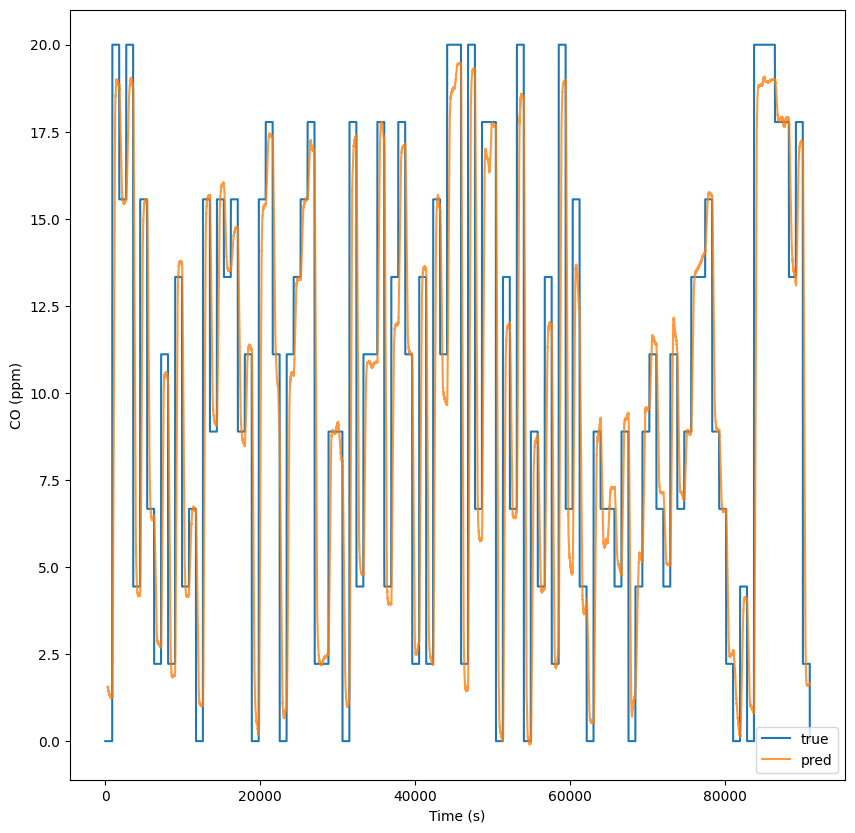

In [16]:
# predを移動平均で平滑化
pred = pd.Series(valid_preds)
pred_smooth = pred.rolling(window=1000).mean()
# y_valid, pred_smoothを縦軸、横軸にTime (s)を取り、グラフを描画
plt.figure(figsize=(10, 10))
plt.plot(valid["Time (s)"], y_valid, label="true")
plt.plot(valid["Time (s)"], pred_smooth, label="pred", alpha=0.8)
# 縦軸、横軸にラベルを付ける
plt.xlabel("Time (s)")
plt.ylabel("CO (ppm)")
plt.legend()

## 実行環境のライブラリverを保存

In [17]:
# Pythonのverを確認
!python3 -V

Python 3.11.11


In [18]:
!pip freeze > requirements_time_series_analysis.txt

In [19]:
from google.colab import files

files.download('requirements_time_series_analysis.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>